# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

You can use ** Keras ** to implement your model. Read more at [keras.io](https://keras.io/).

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0)). You are not expected to model your architecture precisely using this model nor get the same performance levels, but this is more to show an exampe of an approach used to solve this particular problem. We encourage you to try out different architectures for yourself and see what works best for you. Here is a useful [forum post](https://discussions.udacity.com/t/goodfellow-et-al-2013-architecture/202363) discussing the architecture as described in the paper.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [8]:
from keras.models import Model, load_model
from six.moves import cPickle as pickle
from mycode import modelEval

pickle_file = 'mycode/MNIST-1.pickle'
with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    train_sequences = save['train_sequences']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    test_sequences = save['test_sequences']
    del save

clf = load_model('mycode/MNIST-1.h5')
evaluate = clf.evaluate(test_dataset, [test_sequences, test_labels[:,:,0], test_labels[:,:,1], 
                            test_labels[:,:,2], test_labels[:,:,3], test_labels[:,:,4]])
print "\n", evaluate
print "\nAccuracy:", modelEval.accuracy(clf, test_dataset, test_sequences, test_labels)

30000/30000 [==============================] - 36s    

[0.67993092880249029, 3.2880504784770892e-06, 0.11162834855119387, 0.13236389057338238, 0.11232895022233327, 0.1099038927949965, 0.21370255805325383, 1.0, 0.96719999999999995, 0.96060000000000001, 0.96583333333333332, 0.96589999999999998, 0.9240666666666667]

Accuracy 0.8072


### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:** I first designed a multilayer convolutional network, based on the Keras documentation (https://keras.io/getting-started/sequential-model-guide/#examples), and made certain it performed well on single digits from the Keras MNIST dataset.

Next I modified the data sets to use random combinations of up to five samples from the MNIST data and added parallel softmax outputs in a similar fashion to the Google architecture linked above. This model was almost 80% accurate on 5-digit combinations and >95% per digit accuracy.

Adding in additional convoluational layers to more closely match the Google architecture produced 85.2% accuracy (MNIST-xlg3-1 above).

After making some modifications using for the SVHN data, I retested training on this dataset with the different layer sizes and achieved **91.6%** accuracy on 5-digit combinations and ~98% accuracy on each digit (MNIST-xlg3-3 above).

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:** My final archecture uses eight convoluational layers, one large dense layers, and then a small dense layer for each of the six outputs (length of sequence and five digits). Each convolution layer uses maxpooling and batch normalization. All layers use ReLu activation, except the output, which use Softmax. All layers but the input and output use dropout.

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:** I trained my model using the adadelta optimizer. Researching similar image classification problems indicated that Adam and Adadelta are common choices for this type of application. I chose to use a batch size of 100, but didn't thoroughly test adjusting this parameter.

I tested generating my synthetic dataset a few different ways, but settled on randomly generating numbers between 0 and 99,999, using the length of that number to then grab a matching number of random samples from the training or test sets, concatenating those images together, then resizing the resulting image back to 28x28. In the cases where less than five digits were used, I inserted blank space into the image so that there is more consistency in the shape of the numbers. 5,000,000 new training samples were generated using the original training data and 30,000 new testing samples were generated using the original testing data.

Samples of generated images can be found below.

('Training set:', (1000000, 1, 28, 28), (1000000, 11, 5), (1000000, 5))
('Test set:', (30000, 1, 28, 28), (30000, 11, 5), (30000, 5))


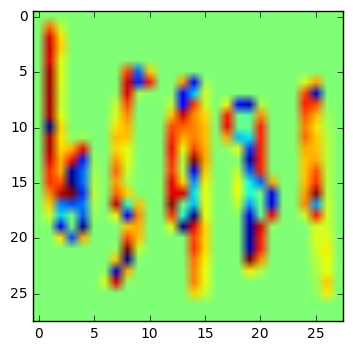

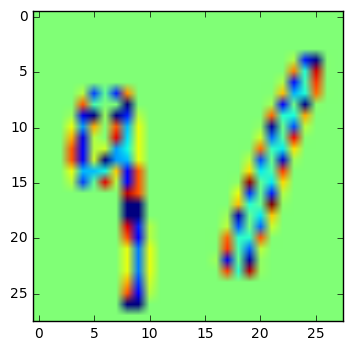

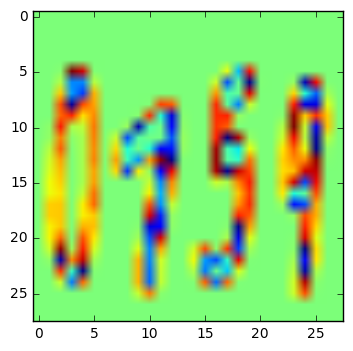

In [9]:
import numpy as np
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt

%matplotlib inline

pickle_file = 'mycode/MNIST-1.pickle'
with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    train_sequences = save['train_sequences']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    test_sequences = save['test_sequences']
    del save

print('Training set:', train_dataset.shape, train_labels.shape, train_sequences.shape)
print('Test set:', test_dataset.shape, test_labels.shape, test_sequences.shape)

for foo in range(3):
    image = np.array(train_dataset[np.random.randint(train_dataset.shape[0]), 0, :, :])
    plt.figure()
    plt.imshow(image)

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [11]:
from keras.models import Model, load_model
from six.moves import cPickle as pickle
from mycode import modelEval

pickle_file = 'mycode/SVHN-1.pickle'
with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    train_sequences = save['train_sequences']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    test_sequences = save['test_sequences']
    del save

clf = load_model('mycode/SVHN-1.h5')
evaluate = clf.evaluate(test_dataset, [test_sequences, test_labels[:,:,0], test_labels[:,:,1], 
                            test_labels[:,:,2], test_labels[:,:,3], test_labels[:,:,4]])
print "\n", evaluate
print "\nAccuracy:", modelEval.accuracy(clf, test_dataset, test_sequences, test_labels)

13060/13060 [==============================] - 17s    

[1.4046416268414414, 0.1800830563624724, 0.37338758502980968, 0.50898712178831995, 0.29800408698370962, 0.042679913584447775, 0.0014998711334241221, 0.95398162327718228, 0.89310872894333848, 0.85765696784073508, 0.9175344563552833, 0.98897396630934153, 0.99984686064318529]

0.751225114855


### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:** To prepare the training and testing data, I looped through all of the files in the two directories and pulled each image's sequence information from the digitStruct files. To make the images consistent, I resized them all to 32x32 and also converted them to greyscale.

Using the same model that achieved 85% accuracy on the previous dataset, the SVHN data was only able to produce an accuracy of 17.4%.

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:** I tested many different options for improving performance, but ultimately it came down to improving the dataset. 

Increasing the large dense layer from 1024 nodes to 3096 decreased accuracy on the test set to 14%.

Increasing the number of nodes in the first two convolutional layers increased the test set accuracy to 19.3%. This change was then implmented on the MNIST sequence set and increased accuracy on the generated data from 85% to 92%.

Switching to training on the "extra" dataset lowered accuracy to 16%.

Resampling the "extra" dataset to have even numbers of cases for each sequence length lowered accuracy to 14.1%.

Increasing the numbers of epochs of training from 40 to 100 on the train set increased accuracy to 23.8%.

Reformatting the "extra" set to only use sequences of four or less numbers lowered accuracy to 11%.

Adding an extra dense layer with 32 nodes between the 1024-node dense layer and the output layers lowered accuracy to 17.4%.

Increasing the number of training epochs to 1000 (~6 hours on a GPU), using the original training data, increased the accuracy on the test set to 27.9%.

Ultimately, the biggest improvement came from re-generating the test set data to crop to the bounding boxes before resizing to 32x32 pixels. Reducing the large dense layer led to small improvements in test accuracy, but the best model came from increasing the dense layer size to 3096 nodes and running it much longer (1000 epochs). This produced an accuracy of 77.5%.

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:** Initial result: 17.4% accuracy. Final result: 77.5% accuracy. This model is still not doing a good enough job at classifying numbers to be very useful in a real world application, but is sufficiently good to attempt classifying pictures of numbers that I take myself.

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [15]:
import numpy as np
from keras.models import Model, load_model
from mycode import modelEval, genNew

photos_dataset, photos_labels, photos_sequences = genNew.generateData('mycode/photos')
print photos_dataset.shape, photos_labels.shape, photos_sequences.shape
print np.mean(photos_dataset)

clf = load_model('mycode/SVHN-1.h5')
evaluate = clf.evaluate(photos_dataset, [photos_sequences, photos_labels[:,:,0], photos_labels[:,:,1], 
                            photos_labels[:,:,2], photos_labels[:,:,3], photos_labels[:,:,4]])
print "\n", evaluate
print "\nAccuracy: ", modelEval.accuracy(clf, photos_dataset, photos_sequences, photos_labels)

Images loaded: 8
(8, 1, 32, 32) (8, 11, 5) (8, 5)
131.710083008
8/8 [==============================] - 1s

[3.7404119968414307, 0.99434816837310791, 0.73627305030822754, 0.94024574756622314, 0.13292874395847321, 0.93645703792572021, 0.00015911104856058955, 0.75, 0.625, 0.625, 1.0, 0.875, 1.0]

Accuracy:  0.375


### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:** The photos I took include a mix of different font styles, colors, textures, and luminance. There were initially a number of extra distractors in each photo, but I cropped them further in order to try to improve results.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mycode import genNew

photos_dataset, photos_labels, photos_sequences = genNew.generateData('photos')

for sample in photos_dataset:
    image = np.array(sample) # [0, :, :])
    plt.figure()
    plt.imshow(image)

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:** Neither of my best models were able to identify the sequences of numbers in these photos as well as their test set data. The models were able to identify the length and digits with about half the accuracy of the models on their test data:

77% "cropped" digits model: 50% accuracy on photo sequences.
Categorical Accuracy: Length: [0.875], Digits: [0.75, 0.625, 1.0, 0.875, 1.0]

28% "whole" digits model: 12.5% accuracy on photo sequences.
Categorical Accuracy: Length: [0.375], Digits: [0.5, 0.25, 0.625, 0.875, 1.0]

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
## Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

13060/13060 [==============================] - 21s    

[1.5127832590529602, 0.21333401355048096, 0.39991356353981455, 0.52897178630186259, 0.30633866553199102, 0.056585699713761831, 0.0014463743672721875, 0.0061931543185904762, 0.94471669218989285, 0.88177641653905059, 0.85306278713629402, 0.91638591117917301, 0.98637059724349163, 0.99984686064318529, 0.31646248085758039]

Test data accuracy: 0.745865237366
Images loaded: 8

Photos accuracy: 0.375


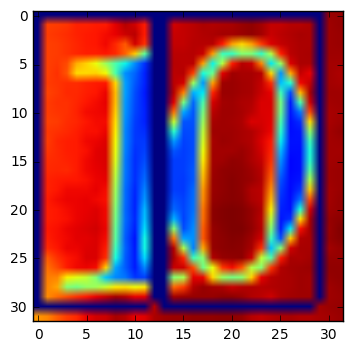

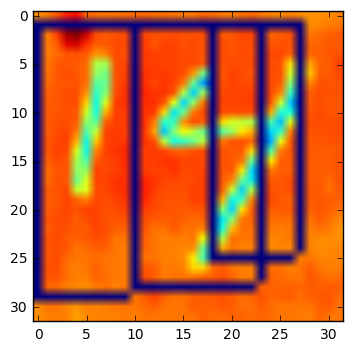

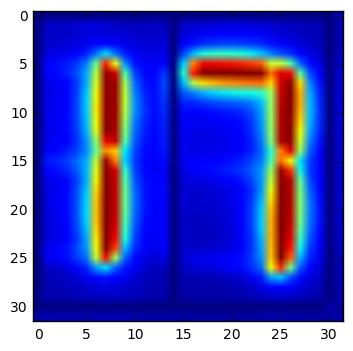

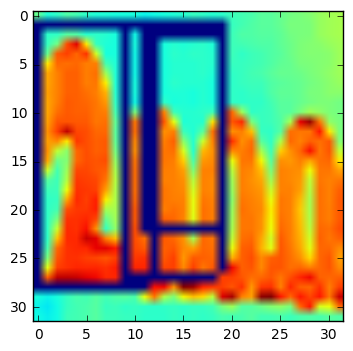

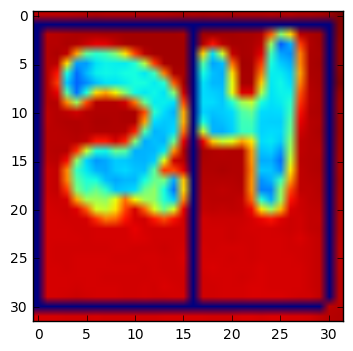

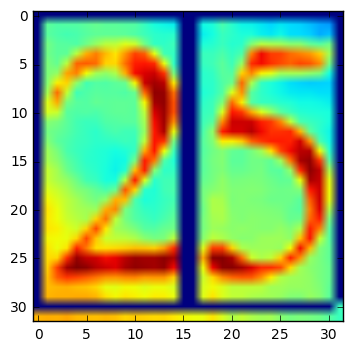

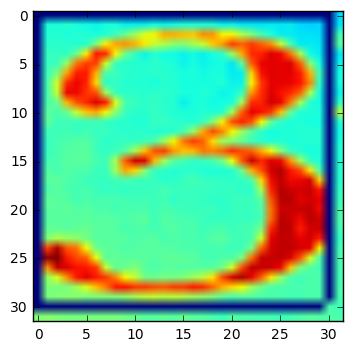

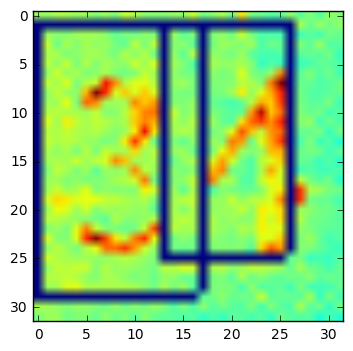

In [20]:
from keras.models import Model, load_model
import numpy as np
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
from mycode import genNew, modelEval

image_size = 54

pickle_file = 'mycode/SVHN-BB-1.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  train_sequences = save['train_sequences']
  train_bboxes = save['train_bboxes']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  test_sequences = save['test_sequences']
  test_bboxes = save['test_bboxes']
  del save

clf = load_model('mycode/SVHN-BB-1.h5')
evaluate = clf.evaluate(test_dataset, [test_sequences, test_labels[:,:,0], test_labels[:,:,1], 
                            test_labels[:,:,2], test_labels[:,:,3], test_labels[:,:,4], test_bboxes])
print "\n", evaluate
print "\nTest data accuracy:", modelEval.accuracy(clf, test_dataset, test_sequences, test_labels)

photos_dataset, photos_labels, photos_sequences = genNew.generateData('mycode/photos')
print "Photos accuracy:", modelEval.accuracy(clf, photos_dataset, photos_sequences, photos_labels)
preds = clf.predict(photos_dataset)

for sample in range(8):
    image = np.array(photos_dataset[sample, 0, :, :])
    for index in range(5):
        if preds[6][sample][5 * index + 0] > 0.5:
            top = int((image_size - 1) * preds[6][sample][5 * index + 1])
            left = int((image_size - 1) * preds[6][sample][5 * index + 2])
            bottom = int((image_size - 1) * (preds[6][sample][5 * index + 3] + preds[6][sample][5 * index + 1]))
            right = int((image_size - 1) * (preds[6][sample][5 * index + 4] + preds[6][sample][5 * index + 2]))
            image[top:bottom, left] = 0
            image[top:bottom, right] = 0
            image[top, left:right] = 0
            image[bottom, left:right] = 0
    plt.figure()
    plt.imshow(image)

### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:** I used the uncropped images that previously could only be identified with ~27% accuracy and added the bounding boxes as an additionaly 25-node output (5 channels x 5 parameters per box). After 100 epochs the network reached the same ~24% accuracy that the model had reached at that point without the bounding box information.

The model trained using cropped images achieves marginally higher accuracy (77.7%) when using the bounding box information as an additional set of outputs.

The classification results do not change significantly with localization included.

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:** The network trained including the bounding box information actually missed one extra image and now has an accuracy of 37.5% instead of 50%.

The bounding box information isn't perfect, but reasonably identifies the presence and location of the digits in most of the photos above.

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.